In [1]:
#Import Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Importing Dependencies
import pandas as pd
import numpy as np
from numpy import nan

import csv
import nltk
import pickle

In [2]:
#Pre-Processing + Custom Class Integration
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator


#Model Imports
from sklearn.linear_model import LinearRegression, ElasticNetCV, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor

#Model Boosting
from sklearn.ensemble import BaggingRegressor

#Model Metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error


#GridSearch
from sklearn.model_selection import GridSearchCV

#Scipy Integration for Sparse Matrixes
from scipy import sparse

#Additional Feature Engineering - NLP Text Data Import
from sklearn.feature_extraction.text import TfidfVectorizer

#PipeLine Imports
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline


#Multi-threaded Processing
from sklearn.externals import joblib

In [3]:
# Visualisation Libraries
from yellowbrick.regressor import ResidualsPlot

In [4]:
pd.set_option('display.max_columns', 500)

In [5]:
### Classes Custom Standard_Scaler  

class Standard_Scaler(BaseEstimator,TransformerMixin):
    
    def __init__(self, X, text_columns = None, numerical_columns= None):
        self.scaler = StandardScaler()
        self.text_columns = text_columns
        self.numerical_columns = numerical_columns
    
    def fit(self, X, *args):
        self.numerical_columns = X.select_dtypes(include= [np.number])
        self.text_columns = X[X.columns.difference(list(self.numerical_columns.columns))]
        self.scaler = self.scaler.fit(self.numerical_columns)
        return self
    
    
    def transform(self, X, *args):
        self.text_columns = X[X.columns.difference(list(self.numerical_columns.columns))]
        self.numerical_columns = X.select_dtypes(include= [np.number])
        # Fitting & Transforming The 
        numerical = pd.DataFrame(self.scaler.transform(self.numerical_columns), columns = X.columns.difference(['Article_Text']),
                                index = self.numerical_columns.index)
        
        # Horizontally Stacking The Scaled Numerical Data With The Text Data
        X = pd.concat([numerical, self.text_columns], axis=1, sort=True)
        
        return X

In [6]:
class TFID_Vectorizer(BaseEstimator,TransformerMixin):
    
    def __init__(self, X, ngram_range = None, min_df = None, max_df = None, 
                 max_features= None):
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        self.max_features = max_features
        self.tvec = TfidfVectorizer(stop_words='english', ngram_range = self.ngram_range, min_df= self.min_df, 
                                    max_df = self.max_df, max_features = self.max_features)
    
    def fit(self, X, *args):
        self.text_columns = X.select_dtypes('object')['Article_Text']
        self.tvec = self.tvec.fit(self.text_columns)
        return self
    
    
    def transform(self, X, *args):
        self.text_columns = X.select_dtypes('object')['Article_Text']
        self.numerical_columns = X[X.columns.difference(['Article_Text'])]
        
        X = self.tvec.transform(self.text_columns)
        self.sparse_numerical_data = sparse.csr_matrix(self.numerical_columns)
        
        #Concatenating The Sparse Matrices Together
        X = sparse.hstack([X, self.sparse_numerical_data])
        
        return X

In [18]:
cleaned_df = pd.read_pickle('Ignore/merged_web_page_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)

In [26]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14469 entries, 0 to 14468
Data columns (total 69 columns):
Url                                                                   14469 non-null object
Evergreen_Score                                                       14469 non-null float64
Total_Shares                                                          14469 non-null int64
Published_Date                                                        14469 non-null datetime64[ns]
Word_Count                                                            14469 non-null int64
num_linking_domains                                                   14469 non-null float64
Article_Text                                                          14469 non-null object
Article_Text_Length                                                   14469 non-null int64
Has_Top_Image                                                         14469 non-null int64
Number_of_Movies                                         

In [8]:
X = cleaned_df
y = cleaned_df.pop('Total_Shares')
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)

In [9]:
New_Scaler = Standard_Scaler(cleaned_df)
TFID = TFID_Vectorizer(cleaned_df, (0,4), 0.01, 0.5, None)

##  Models To Test

In [5]:
Linear_Regression = LinearRegression()
RFR = RandomForestRegressor(n_estimators=100)
Ridge = RidgeCV(alphas=(0.0001, 0.001, 0.01, 0.1, 1.0 ), cv = 5)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
# y_train.reset_index(drop=True, inplace=True)
# y_test.reset_index(drop=True, inplace=True)

------------------------------------------------------------------------------------------------------------------------------------------------

## 1. Testing That The TVEC + StandardScaler Give The Same Scores As The Manual Approach (To Do)

In [6]:
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
numerical_columns = cleaned_df.select_dtypes(np.number)
text_columns = cleaned_df.select_dtypes('object')
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text'], inplace=True)

In [7]:
#1 Initialize The Scaler
scaler = StandardScaler()
X = cleaned_df
y = cleaned_df.pop('Total_Shares')

In [8]:
#2 Setup A Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size = 0.2, random_state= 1)

In [15]:
#3 Performing TFID Vectorizing Upon The Text Data
vectorizer = TfidfVectorizer(stop_words = 'english'
                            ,min_df=3, 
                             ngram_range=(1, 4),
                             max_features = 1000,
                            )

#Ensuring That All Of The Rows Are String Type
# X_train['Article_Text'] = X_train['Article_Text'].astype(str)
# X_test['Article_Text'] = X_test['Article_Text'].astype(str)

In [99]:
X2_train_titles = pickle.load(open('X2_train_titles.pkl', 'rb'))
X2_test_titles = pickle.load(open('X2_test_titles.pkl','rb'))

In [100]:
# Drop The Additional Text Columns - Potentially Revert This :)
X_train.drop(axis=1, columns = ['Article_Text', 'Meta_Description', 'Title_Text'], inplace= True)
X_test.drop(axis=1, columns = ['Article_Text', 'Meta_Description', 'Title_Text'], inplace= True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [101]:
X_train.shape

(12770, 60)

In [102]:
X_test.shape

(3193, 60)

In [103]:
test_one = pd.DataFrame(X2_train_titles.toarray())
test_two = pd.DataFrame(X2_test_titles.toarray())

In [104]:
test_one.shape

(12770, 1000)

In [105]:
test_two.shape

(3193, 1000)

In [106]:
#Merge The Text Data With The DataFrame Matrix

In [107]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [108]:
X_train = pd.concat([X_train, test_one], axis=1)
X_test = pd.concat([X_test, test_two], axis=1)

In [109]:
X_train.shape

(12770, 1060)

In [114]:
X_test.shape

(3193, 1060)

In [115]:
#4 Apply Standardized Scaling To The Original Matrix.
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [116]:
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [29]:
Lasso_Test = LassoCV(n_alphas=100)

In [30]:
Lasso_Test.fit(X_train, y_train)
Lasso_Test.score(X_train, y_train)

ValueError: could not convert string to float: 'Having a thorough content strategy plays a vital part when it comes to your brands success. In today’s day and age, not using content marketing strategies is a joke. Content marketing, if used efficiently gives your business a major boost. Today, in this article we will discuss why your business needs content marketing?\n\nBuilds Online Presence\n\nHaving a strong online presence is this advanced, digital world is all digital marketing is about. Content is the fuel that drives site visits and other key measurements. Increasing your online awareness helps your content to reach your intended targeted audience as well as the general public.\n\nAdvance Sales Cycles\n\nThe best content marketing firms understand the roles that various types of content play at specific stages of the sales cycle. By aligning content with buyers’ needs at each step of the journey, content marketing makes it easier for them to navigate the road from prospect to satisfied customer.\n\nGreat for Organic Search (SEO)\n\nSearch engine algorithms are always changing, but as long as you consistently create and keep your content current (up to date, not falling behind the times), informative (solving problems or answering questions), and relevant (has to do with the search word or phrase), it will rank higher and longer in the search engines. This way your websites content stays ahead in the game and thus making a name on the world wide web.\n\nWe hope you enjoyed this article, stay tuned for more!'

In [31]:
Lasso_Test.score(X_test, y_test)

NotFittedError: This LassoCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### Testing The Pipeline Vs The Manual Approach Above 

In [78]:
X_train

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Tag_Length,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']",0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,...,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.82,1438,1.0,10067,1,0,0,13,1,77,1566,42.04,14.6,14.97,15.9,18.7,77,19,1,106712,10067,9.433803,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.023145,0.018345,0.021465,0.000000,0.000000,0.0,0.022911,0.019945,0.027130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025417,0.000000,0.041778,0.000000,0.000000,0.000000,0.000000,0.0

In [9]:
New_Scaler = Standard_Scaler(cleaned_df)
TFID = TFID_Vectorizer(cleaned_df, (0,4), 3, None, 1000)
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
X = cleaned_df
y = cleaned_df.pop('Total_Shares')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

NameError: name 'Standard_Scaler' is not defined

In [10]:
pipe_lasso = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID ),
                   ('Model', LassoCV(n_alphas=100))])

pipe_lasso.fit(X_train)
pipe_lasso.score(X_train)

NameError: name 'New_Scaler' is not defined

In [ ]:
pipe_lasso.score(X_test)

------------------------------------------------------------------------------------------------------------------------------------------------

# Experiments 

## 2.  Testing The Data In A Simple Pipeline With Regularization (Needs Debugging)

In [77]:
cleaned_df

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Text,Title_Tag_Length,Meta_Description,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']"
0,1.54,4767,1.0,"Some of the links below are affiliate links, s...",27301,1,0,0,42,1,261,4810,46.98,16.8,17.43,15.1,21.2,Affiliate Marketing for Dummies: A Smart Guide...,79,A step-by-step affiliate marketing for dummies...,151,1,186434,27301,14.643788,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.44,1181,2.0,Would you like to make money while you sleep?\...,6519,1,0,0,24,1,65,1154,53.99,14.2,15.29,13.2,17.6,HOW TO USE AFFILIATE MARKETING TO MAKE MONEY B...,69,Do you want to make money while you sleep? Her...,150,1,96481,6519,6.756771,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.68,996,12.0,Learn three simple strategies to help you stac...,5916,1,0,0,12,1,65,1001,46.03,15.1,16.04,14.5,18.6,How to Build a Profitable Business Online by S...,60,Learn three simple strategies to help you stac...,122,1,85973,5916,6.881230,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.30,8996,3.0,I never thought this would happen to me.\n\nIn...,39589,1,0,0,113,1,353,6529,50.70,13.3,13.01,13.5,17.0,How To Make Money With Affiliate Marketing In ...,63,I made $150k last year in affiliate marketing ...,114,1,421899,39589,9.383525,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.53,2226,1.0,This post may contain affiliate links. Please ...,12657,1,0,0,28,1,140,2227,59.06,12.2,12.84,13.1,15.2,How To Make Money With Affiliate Marketing For...,73,No Meta_Description,19,1,149458,12657,8.468600,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.18,1489,0.0,Affiliate marketing is one of the easiest ways...,9050,1,0,0,10,1,82,1481,44.11,15.9,16.42,14.7,20.5,The 5 BEST Affiliate Marketing Networks for Ne...,72,Affiliate marketing networks offer bloggers ac...,159,1,80949,9050,11.179879,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2.05,698,0.0,Making a full-time income with affiliate marke...,4741,1,0,0,10,1,48,811,62.72,10.8,12.83,13.0,14.2,8 Creative Ways to Monetize a Blog with Affili...,59,No Meta_Description,19,1,72053,4741,6.579879,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0

In [58]:
sdf = pd.SparseDataFrame(TFID.fit_transform(X_train))

In [59]:
sdf.shape

(12594, 813)

In [60]:
sdf_two = pd.SparseDataFrame(TFID.transform(X_test))
sdf_two.shape

(3149, 813)

In [61]:
X_train.head(2)

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Tag_Length,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']"
2506,0.00,280,0.0,Having a thorough content strategy plays a vit...,1476,1,0,0,2,0,12,243,49.08,14.0,15.78,14.4,17.8,41,118,1,35498,1476,4.157981,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2311,0.36,1966,1.0,Recently google found that one in every 20 sea...,12467,1,0,0,15,1,97,2176,28.71,23.9,25.54,18.2,30.4,55,176,1,157072,12467,7.937124,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [62]:
X_test.head(2)

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Tag_Length,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']"
6422,0.0,127,0.0,http://amzn.to/2pFBR3F If you feel utterly los...,814,1,0,0,44,0,5,144,59.16,12.2,13.74,11.6,14.9,131,816,1,254738,814,0.319544,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8758,0.0,1016,0.0,Influencer marketing is one of the most profit...,6171,1,0,0,4,1,69,1007,53.75,12.2,12.43,15.0,15.8,56,162,1,59072,6171,10.446574,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
y_train.head(2)

2506    4
2311    5
Name: Total_Shares, dtype: int64

In [64]:
y_test.head(2)

6422    0
8758    0
Name: Total_Shares, dtype: int64

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [65]:
TFID = TFID_Vectorizer(cleaned_df, (0,2), 0.05, 0.5, None)
ridge_alphas = np.logspace(0, 5 , 200)
Ridge = RidgeCV(alphas= ridge_alphas)

pipe_ridge = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID),
                   ('Model', Ridge)])

In [66]:
pipe_ridge.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('sc1',
                 Standard_Scaler(X=None,
                                 numerical_columns=       Evergreen_Score  Word_Count  num_linking_domains  Article_Text_Length  \
2506              0.00         280                  0.0                 1476   
2311              0.36        1966                  1.0                12467   
4936              0.32        1490                  1.0                 8405   
4457              0.00         613                  0.0                 3678   
14392             0.00         115                  0.0                  614   
14350             0.19         803                  0.0                 4630   
161               0.56         962                  0.0                 5751   
689               0.73         303                  0.0                 1861   
11275             0.37        1438                  0.0                 8578   
12117             0.18        1053                  0.0       

In [67]:
pipe_ridge.score(X_train, y_train)

0.0004030606358621514

In [68]:
pipe_ridge.score(X_test, y_test)

-0.0005788176386554156

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Non-logged Data Lasso - Complete

In [72]:
TFID = TFID_Vectorizer(cleaned_df, (0,2), 0.05, 0.5, None)

pipe_ridge = Pipeline([('sc1', StandardScaler()),
                   ('Model', LassoCV(alphas = np.linspace(0.01, 10, 50), n_jobs=-1))])

In [73]:
pipe_ridge.fit(X_train.select_dtypes(['int','float']), y_train)

C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69823055.55365872, tolerance: 110530.4617081944
  tol, rng, random, positive)
C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\coordinate_descent.py:471: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8912375.187268972, tolerance: 82202.66527750122
  tol, rng, random, positive)
C:\Users\james.DESKTOP-36N7TSQ\AppData\Roaming\Python\Python37\site-packages\sk

Pipeline(memory=None,
         steps=[('sc1',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('Model',
                 LassoCV(alphas=array([ 0.01      ,  0.21387755,  0.4177551 ,  0.62163265,  0.8255102 ,
        1.02938776,  1.23326531,  1.43714286,  1.64102041,  1.84489796,
        2.04877551,  2.25265306,  2.45653061,  2.66040816,  2.86428571,
        3.06816327,  3.27204082,  3.47591837,  3.67979592,  3.88367347,
        4.08755102,  4.291...
        7.14571429,  7.34959184,  7.55346939,  7.75734694,  7.96122449,
        8.16510204,  8.36897959,  8.57285714,  8.77673469,  8.98061224,
        9.1844898 ,  9.38836735,  9.5922449 ,  9.79612245, 10.        ]),
                         copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
                         max_iter=1000, n_alphas=100, n_jobs=-1,
                         normalize=False, positive=False, precompute='auto',
                         random_state=None, selection='cyclic'

In [74]:
pipe_ridge.score(X_train.select_dtypes(['int','float']), y_train)

0.4040412072187083

In [75]:
pipe_ridge.score(X_test.select_dtypes(['int','float']), y_test)

0.14494142579450875

------------------------------------------------------------------------------------------------------------------------------------------------------

## Log The Target Variable - Complete

In [11]:
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)

In [12]:
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))

In [13]:
X = cleaned_df
y = cleaned_df.pop('Total_Shares')

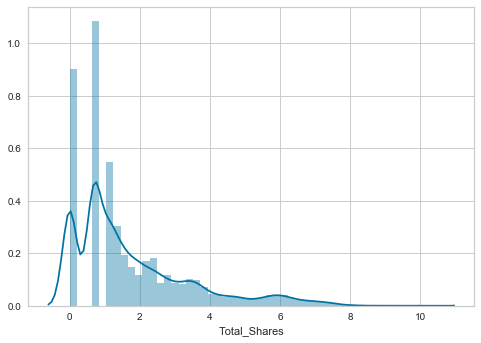

In [14]:
sns.distplot(y)
plt.show()

In [15]:
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)

## 1. Log Data - Lasso - Complete

In [46]:
TFID = TFID_Vectorizer(cleaned_df, (0,2), 0.05, 0.5, None)

pipe_lasso = Pipeline([('sc1', StandardScaler()),
                   ('Model', LassoCV(alphas = np.linspace(0.01, 10, 50), n_jobs=1))])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [48]:
pipe_lasso.fit(X_train.select_dtypes(['int','float']), y_train)
pipe_lasso.score(X_train.select_dtypes(['int','float']), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.6904135476302053

In [49]:
pipe_lasso.score(X_test.select_dtypes(['int','float']), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.6789321592016851

In [50]:
predictions = pipe_lasso.predict(X_test.select_dtypes(['int','float']))

/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [51]:
predictions.shape

(3149,)

In [19]:
from yellowbrick.regressor import ResidualsPlot, PredictionError, AlphaSelection, CooksDistance
from yellowbrick.model_selection import LearningCurve, CVScores

model = LassoCV(alphas = np.linspace(0.01, 10, 50))

model.fit(X_train.select_dtypes(['float', 'int']), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of i

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

LassoCV(alphas=array([ 0.01   ,  0.21388,  0.41776,  0.62163,  0.82551,  1.02939,
        1.23327,  1.43714,  1.64102,  1.8449 ,  2.04878,  2.25265,
        2.45653,  2.66041,  2.86429,  3.06816,  3.27204,  3.47592,
        3.6798 ,  3.88367,  4.08755,  4.29143,  4.49531,  4.69918,
        4.90306,  5.10694...6898,
        8.57286,  8.77673,  8.98061,  9.18449,  9.38837,  9.59224,
        9.79612, 10.     ]),
    copy_X=True, cv='warn', eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=None, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [20]:
model.score(X_train.select_dtypes(['float', 'int']), y_train)

0.2763553394670315

In [21]:
model.score(X_test.select_dtypes(['float', 'int']), y_test)

0.3392930872764105

In [34]:
residuals = model.predict(X_train.select_dtypes(['float', 'int'])) - y_train

In [43]:
X_train

,Evergreen_Score,Word_Count,num_linking_domains,Article_Text,Article_Text_Length,Has_Top_Image,Number_of_Movies,Article_Is_Media_News,Number_Of_Images,Is_Valid_Body,Number_Of_Sentences,Lexicon_Count,Flesch_Reading_Ease_formula,Flesch_Kincaid_Grade_Level,FOG_Scale,SMOG_Index,ARI_Index,Title_Text,Title_Tag_Length,Meta_Description,Meta_Description_Length,SSL,Page_Size_In_Bytes,Plain_Text_Size,Plain_Text_Rate,Has_Referring_Domains,Has_Article_Amplifiers,Has_Author_Name,Topic_Content Marketing,Topic_Copywriting,Topic_Display Advertising,Topic_Email Marketing,Topic_Growth Marketing,Topic_Influencer Marketing,Topic_Link Building,Topic_Marketing Automation,Topic_Podcast Marketing,Topic_Search Engine Marketing,Topic_Social Media Marketing,Topic_Video Marketing,Topic_Website Design,Encoding_ISO-8859-1,Encoding_UTF-8,Encoding_iso-8859-1,Encoding_utf-8,Encoding_windows-1252,Number_Of_Article_Amplifiers,"article_types_['how_to_article', 'general_article']","article_types_['how_to_article', 'infographic', 'general_article']","article_types_['how_to_article', 'list', 'general_article']","article_types_['how_to_article', 'newsletter', 'general_article']","article_types_['how_to_article', 'what_post', 'general_article']","article_types_['how_to_article', 'why_post', 'general_article']","article_types_['infographic', 'general_article']","article_types_['list', 'general_article']","article_types_['list', 'infographic', 'general_article']","article_types_['list', 'newsletter', 'general_article']","article_types_['newsletter', 'general_article']","article_types_['what_post', 'general_article']","article_types_['what_post', 'infographic', 'general_article']","article_types_['what_post', 'newsletter', 'general_article']","article_types_['why_post', 'general_article']","article_types_['why_post', 'newsletter', 'general_article']"
9176,0.82,1438,1.0,To automate or not to automate – that is not a...,10067,1,0,0,13,1,77,1566,42.04,14.6,14.97,15.9,18.7,3 major ways pharma can accomplish its marketi...,77,No Meta_Description,19,1,106712,10067,9.433803,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
14646,0.19,75,0.0,We use cookies to ensure that we give you the ...,153,1,0,0,26,0,2,31,81.12,5.8,8.78,0.0,5.0,Blackwater Open Farm Ecommerce Website Design ...,57,No Meta_Description,19,1,85233,153,0.179508,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3406,0.00,1169,0.0,Share Pin 0 Shares\n\nSearch Engine Optimizati...,6921,1,0,0,16,1,69,1136,51.82,12.9,14.00,14.9,16.5,How to Build Right Content Marketing Strategy ...,60,This article describe the content marketing st...,147,1,128586,6921,5.382390,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3305,0.00,64,0.0,AdweekThird-Party Influencer Marketing Platfor...,481,1,0,0,3,0,2,65,4.65,20.7,21.62,0.0,25.2,Third-Party Influencer Marketing Platforms Can...,115,AdweekThird-Party Influencer Marketing Platfor...,296,1,63648,481,0.755719,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8175,0.18,42,0.0,Published 11 months ago\n\nCoin spectator is a...,313,1,0,0,9,0,4,46,47.49,10.4,13.95,13.6,13.9,Why Blockchain Will Not Help Influencer Market...,67,NaN,0,1,47164,313,0.663642,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,0.00,231,0.0,Affiliate link disclosure\n\nWe may sometimes ...,1329,1,0,0,3,0,9,227,47.05,14.7,15.60,15.5,17.8,Affiliate Marketing | The Parent Pack,37,No Meta_Description,19,1,60226,1329,2.206688,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5192,0.35,1162,0.0,While it’s trendy these days in marketing to f...,6858,1,0,0,18,1,57,1162,51.82,12.9,14.04,13.6,15.6,6 Tips To Get The

In [ ]:
polynomials --> X_train['title_tag_length'] ** 2 

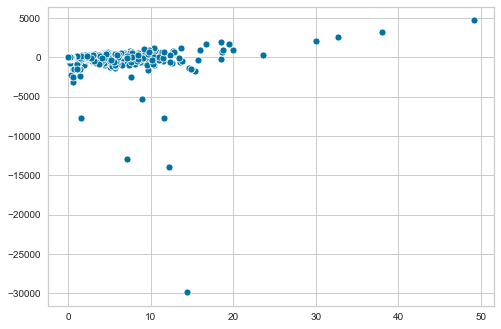

In [46]:
sns.scatterplot(x = X_train['Evergreen_Score'].values , y= residuals.values)
plt.show()

In [40]:
cross_val_score(pipe_lasso, X_train.select_dtypes(['int','float']), y_train, cv =5 )

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversion

array([0.67941344, 0.68699461, 0.69939519, 0.65843474, 0.70051817])

In [46]:
df = pipeline_model_results(0, 'logged', pipe_lasso, X_train.select_dtypes(['int','float']), X_test.select_dtypes(['int','float']), y_train, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: D

------------------------------------------------------------------------------------------------------------------------------------------------------

## 2. Log Numerical Data - Decision Tree Regressor 

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))

In [6]:
X = cleaned_df
y = cleaned_df.pop('Total_Shares')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [8]:
from sklearn.tree import DecisionTreeRegressor

In [9]:
Decision_Tree_Regressor = DecisionTreeRegressor(random_state=0, max_depth =5)

In [10]:
Decision_Tree_Regressor.fit(X_train.select_dtypes(['int', 'float']), y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [11]:
Decision_Tree_Regressor.score(X_train.select_dtypes(['int', 'float']), y_train)

0.837984930870673

In [12]:
np.mean(cross_val_score(Decision_Tree_Regressor, X_train.select_dtypes(['int', 'float']), y_train, cv =5 ))

0.8294108244723557

In [13]:
Decision_Tree_Regressor.score(X_test.select_dtypes(['int', 'float']), y_test)

0.831984932404803

In [16]:
from os import system
from sklearn.tree import export_graphviz
import pydotplus

def build_tree_image(model, filename='tree.png'):
    dotfile = open("tree.dot", 'w')
    export_graphviz(model, out_file=dotfile, feature_names=X_train.select_dtypes(['int', 'float']).columns, filled=True)
    dotfile.close()
    # comment out this line if you don't have GraphViz yet
    system("dot -Tpng tree.dot -o {0}".format(filename))

In [35]:
import io

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import matplotlib.image as mpimg
from dtreeviz.trees import *

In [39]:
viz = dtreeviz(Decision_Tree_Regressor,
               X_train.select_dtypes(['int', 'float']), y_train = y_train, target_name='Total_Article_Shares',
               feature_names=X_train.select_dtypes(['int', 'float']).columns)
              
viz.view()              

In [23]:
def model_results_new(data, data_type, model, X_train_num, X_test_num, y_train, y_test):
    
    master_dict = {
    'Data_Used': [],
    'Data_Type': [],
    'Model_Name': [],
    'Model_Training_Score' : [],
    'Model_Test_Score': [],
    'Mean_Squared_Error': [],
    'Model_Cross_Val_Score': [],
    'Coefficients/Feature_Importances': [],
    'Grid_Search_Best_Params / Regularization_Params': [],
    'Notes': []
}  
    
    #Update The Data Column With The Type of Data (Numeric vs Text vs All)
    
    if data == 1:
        master_dict['Data_Used'].append('Text + Numerical Data')
    else:
        master_dict['Data_Used'].append('Numerical')
    
    
    #Updating With The Type of Data
        
    if data_type == 'logged':
        master_dict['Data_Type'].append('Logged')
    else:
        master_dict['Data_Type'].append('Non-Logged Data')
        
    
    #Extracting Out All Of The Relevant Information
    
    fitted_model = model.fit(X_train_num, y_train)
    master_dict['Model_Name'].append(str(fitted_model))
    master_dict['Model_Training_Score'].append(fitted_model.score(X_train_num, y_train))
    master_dict['Model_Test_Score'].append(fitted_model.score(X_test_num, y_test))
    predictions = fitted_model.predict(X_test_num) 
    master_dict['Mean_Squared_Error'].append(mean_squared_error(y_test, predictions))
    master_dict['Model_Cross_Val_Score'].append(np.mean(cross_val_score(fitted_model, X_train_num, y_train, cv=5)))

    try:
        master_dict['Coefficients/Feature_Importances'].append(dict(coefficient_values = fitted_model.coef_, 
                                       indexes = X_train_num.columns))
    except:
        master_dict['Coefficients/Feature_Importances'].append(dict(feature_importance_values = fitted_model.feature_importances_, 
                                       indexes = X_train_num.columns))
                      
            
    try:
        master_dict['Grid_Search_Best_Params / Regularization_Params'].append(fitted_model.best_params_)
    except:
        try:
            master_dict['Grid_Search_Best_Params / Regularization_Params'].append(fitted_model.alpha_)
        except:
            master_dict['Grid_Search_Best_Params / Regularization_Params'].append('No Grid Search Used / Regularization Used')
            

    master_dict['Notes'].append(str(fitted_model))
     
    df = pd.DataFrame(master_dict)
    return df

## 3. Log Numerical Data - Random Forest Regressor

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))
X = cleaned_df
y = cleaned_df.pop('Total_Shares')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [6]:
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)

In [7]:
RFR = RandomForestRegressor(n_estimators = 100)

In [8]:
RFR.fit(X_train.select_dtypes(['int', 'float']), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [9]:
RFR.score(X_train.select_dtypes(['int', 'float']), y_train)

0.9725702583765963

In [10]:
RFR.score(X_test.select_dtypes(['int', 'float']), y_test)

0.800246294367632

In [82]:
X_train.select_dtypes(['int', 'float']).columns

Index(['Evergreen_Score', 'Word_Count', 'num_linking_domains',
       'Article_Text_Length', 'Has_Top_Image', 'Number_of_Movies',
       'Article_Is_Media_News', 'Number_Of_Images', 'Is_Valid_Body',
       'Number_Of_Sentences', 'Lexicon_Count', 'Flesch_Reading_Ease_formula',
       'Flesch_Kincaid_Grade_Level', 'FOG_Scale', 'SMOG_Index', 'ARI_Index',
       'Title_Tag_Length', 'Meta_Description_Length', 'SSL',
       'Page_Size_In_Bytes', 'Plain_Text_Size', 'Plain_Text_Rate',
       'Has_Referring_Domains', 'Has_Article_Amplifiers', 'Has_Author_Name',
       'Number_Of_Article_Amplifiers'],
      dtype='object')

In [95]:
df = model_results_new(0, 'logged', RFR, X_train.select_dtypes(['int','float']), X_test.select_dtypes(['int','float']), y_train, y_test)

In [108]:
pickle.dump(df, open('results.pkl', 'wb'))

## 5. Log Numerical Data - Boosting Algorithims (ADA + Gradient Boosting Regressor) - To Do

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))
X = cleaned_df
y = cleaned_df.pop('Total_Shares')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [12]:
GBR = GradientBoostingRegressor(learning_rate=0.025 ,max_depth = 3, n_estimators = 100)

In [13]:
RFR.fit(X_train.select_dtypes(['int', 'float']), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [14]:
RFR.score(X_train.select_dtypes(['int', 'float']), y_train)

0.972606929550614

In [15]:
RFR.score(X_test.select_dtypes(['int', 'float']), y_test)

0.7998232958985416

In [143]:
np.mean(cross_val_score(RFR, X_train.select_dtypes(['int', 'float']), y_train, cv=5 ))

0.8553324631441992

-------------------------------------------------------------------------------------------------------------------------

### ADA Boosting 

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))
X = cleaned_df
y = cleaned_df.pop('Total_Shares')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [17]:
ada_regressor = AdaBoostRegressor(base_estimator= RandomForestRegressor(n_estimators=100),
                                  n_estimators = 10, loss='linear', learning_rate = 0.2)

In [18]:
ada_regressor.fit(X_train.select_dtypes(['int', 'float']), y_train)

AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       oob_score=False,
                       

In [19]:
ada_regressor.score(X_train.select_dtypes(['int', 'float']), y_train)

0.9707802446943619

In [20]:
ada_regressor.score(X_test.select_dtypes(['int', 'float']), y_test)

0.8033459934050311

In [21]:
np.mean(cross_val_score(ada_regressor, X_train.select_dtypes(['int', 'float']), y_train, cv=5 ))

0.8009508660413015

### Bagged MLP Regressor

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))
X = cleaned_df
y = cleaned_df.pop('Total_Shares')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 3)

In [13]:
from sklearn.neural_network import MLPRegressor

In [132]:
nnet = MLPRegressor(hidden_layer_sizes=(8,8,8,8,8), 
                    alpha=0.0001,
                    batch_size='auto',
                    activation='relu',
                    verbose = False)
                   
nnet.fit(X_train.select_dtypes(['int', 'float']), y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(8, 8, 8, 8, 8), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [133]:
nnet.score(X_train.select_dtypes(['int', 'float']), y_train)

-0.009500729835568489

In [134]:
nnet.score(X_test.select_dtypes(['int', 'float']), y_test)

0.09050674151639782

In [ ]:
randomint.math random.int

## So We've Worked Out That Log Transforming Our Target Variable Is Better? Let's See If We Can Improve The Score By Adding in TFID Scores (Needs Debugging)

In [9]:
cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
cleaned_df.dropna(axis= 0, inplace = True)
cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)


In [10]:
cleaned_df['Total_Shares'] = cleaned_df['Total_Shares'].apply(lambda x: np.log1p(x))

In [11]:
X = cleaned_df
y = cleaned_df.pop('Total_Shares')

In [12]:
X['Article_Text'].head(3)

0    Some of the links below are affiliate links, s...
1    Would you like to make money while you sleep?\...
2    Learn three simple strategies to help you stac...
Name: Article_Text, dtype: object

In [13]:
# We Need To Reset The Y_Train + Y_Test For The Sparse Matrix During The Fitting/Scoring Stage.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [16]:
TFID = TFID_Vectorizer(cleaned_df, (0,2), 0.10, 0.5, None)

pipe_lasso_log_TFID = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID ),
                   ('Model', LassoCV())])

In [18]:
pipe_lasso_log_TFID.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/li

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

KeyboardInterrupt: 

In [ ]:
pipe_lasso_log_TFID.score(X_train, y_train)

In [ ]:
pipe_lasso_log_TFID.score(X_test, y_test)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Pipeline Code

## 1. Text Data - Non-Logged - Pipeline

In [ ]:
results = {}

In [ ]:
# pipe_lr = Pipeline([('sc1', New_Scaler),
#                     ('TFID_vec', TFID ),
#                    ('Model', Linear_Regression)])


pipe_ridge = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID),
                   ('Model', Ridge)])

pipe_lasso = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID ),
                   ('Model', LassoCV())])


pipe_random_forest = Pipeline([('sc1', New_Scaler),
                    ('TFID_vec', TFID ),
                   ('Model', RFR)])


pipe_ridge = Pipeline([('sc1', StandardScaler()),
                   ('Model', Ridge)])

## Set Grid Search Parameters

In [ ]:
# grid_params_lr = {'TFID_vec__max_df': [0.25, 0.5],
#                   'TFID_vec__ngram_range': [(0,1), (0,4), (0,6)],
#                   'TFID_vec__min_df': [0.01, 0.05, 0.1]}


grid_params_ridge = {'Model__alphas': [10],
                     'TFID_vec__max_df': [0.25, 0.5],
                     'TFID_vec__ngram_range': [(0,1), (0,4), (0,6)],
                     'TFID_vec__min_df': [0.01, 0.05, 0.1]
                    }


grid_params_lasso = {'Model__n_alphas': [10],
                     'TFID_vec__max_df': [0.25, 0.5],
                     'TFID_vec__ngram_range': [(0,1), (0,4), (0,6)],
                     'TFID_vec__min_df': [0.01, 0.05, 0.1]
                    }


grid_params_RF = {'TFID_vec__max_df': [0.25, 0.5],
                  'TFID_vec__ngram_range': [(0,1), (0,4), (0,6)],
                  'TFID_vec__min_df': [0.01, 0.05, 0.1],
                  'Model__max_depth': [None],
                  'Model__n_estimators': [100],
                  'Model_max_features': [0.5, 0.75, 1.0]}

In [ ]:
X_train.shape

In [ ]:
The alpha range to test for lasso + ridge = 0.0001, 0.001, 0.01, 1. , 10 , 100, 1000

## Setting Up Grid Search Objects 

In [ ]:
# gs_lr = GridSearchCV(estimator = pipe_lr,
#                     param_grid = grid_params_lr,
#                     cv = 5, 
#                     n_jobs = -1)


gs_ridge = GridSearchCV(estimator = pipe_ridge,
                    param_grid = grid_params_ridge,
                    cv = 5,
                    n_jobs = -1)

gs_lasso = GridSearchCV(estimator = pipe_lasso,
                    param_grid = grid_params_lasso,
                    cv = 5,
                    n_jobs = -1)

gs_random_forest = GridSearchCV(estimator = pipe_random_forest,
                    param_grid = grid_params_RF,
                    cv = 5,
                    n_jobs = -1)

------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
gs_random_forest.estimator.get_params().keys()

------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#List of Pipelines for Ease of Iteration
grids = [gs_ridge, gs_lasso, gs_random_forest]


#Dictionary Of Pipelines And Classifier Types For Ease Of Reference
grid_dict = {0: 'Ridge', 1: 'Lasso', 2: 'Random_Forest'}


# Fit the grid search objects
print('Performing model optimizations...')
best_score = 100.00
best_regressor = 0
best_gs = ''
for idx, gs in enumerate(grids):
    
    print('\nEstimator: %s' % grid_dict[idx])
    
    #1. Fit grid search
    gs.fit(X_train, y_train)
    
    #2. Best params
    print('Best params: %s' % gs.best_params_)
    
    #3. Best training data Score
    print('Best training score: %.3f' % gs.best_score_)
    
    #4. Predict on test data with best params
    y_pred = gs.predict(X_test)
    
    #5. Mean Squared Error
    MSE = mean_squared_error(y_test, y_pred)
    
    #Save Data To A Dictionary
    results[idx] = {'Best_Parameters': gs.best_params_,
         'Best_Score': gs.best_score_,
         'y_pred': y_pred,
         'MSE': MSE,
         'Coefficients/Feature_Importances': '',
         'Best_Estimator': gs.best_estimator_}
      
    try: 
        results[idx]['Coefficients/Feature_Importances'] = gs.best_estimator_.named_steps.Model.coef_
    except:
        pass
    
    try:
        results[idx]['Coefficients/Feature_Importances'] = gs.best_estimator.named_steps.Model.feature_importances_
    except:
        pass

    # Track best (highest test accuracy) model
    if MSE < best_score:
        best_score = MSE
        best_gs = gs
        best_regressor = idx
print('\n Model With The Lowest Mean Squared Error %s' % grid_dict[best_regressor])

------------------------------------------------------------------------------------------------------------------------------------------------------

### Articles For Reference
- https://alfurka.github.io/2018-11-18-grid-search/
- https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-3.html

------------------------------------------------------------------------------------------------------------------------------------------------------------------

## PIPELINE TEXT DATA: (Logged + Non-Logged)

In [ ]:
# data = [] 
# results = {}

In [ ]:
# for i in range(2):
#     cleaned_df = pd.read_pickle('Ignore/cleaned_data.pkl')
#     if i == 0:
#         # Take The Log + 0.0001 Of Total Shares
#         cleaned_df['Total_Shares'] = np.log([item + 0.0001 for item in cleaned_df['Total_Shares']])
#     else:
#         pass
    
#     cleaned_df.drop(axis=1, columns = ['Url', 'Published_Date', 'Setences_Text', 'Meta_Description', 'Title_Text' ], inplace=True)
    
#     #Append Cleaned Data To Data List
#     data.append(cleaned_df)

In [ ]:
# for item in data:
    
#     #Train Test Split For Data
#     X = item
#     y = item.pop('Total_Shares')
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     #Construct Some Pipelines
    
#     pipe_lr = Pipeline([('sc1', Standard_Scaler()),
#                        ('linear_regression', LinearRegression())])
    
    
#     #Initialize Models
#     scaler = StandardScaler()
    
#     X_train